In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Czech coins/

/gdrive/MyDrive/Czech coins


In [4]:
ls

01czk/  02czk/  05czk/  10czk/  20czk/  50czk/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [7]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=20
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Czech coins",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1878 files belonging to 6 classes.


In [9]:
class_names = dataset.class_names
class_names

['01czk', '02czk', '05czk', '10czk', '20czk', '50czk']

In [10]:
len(dataset)

31

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[254.     254.     254.    ]
  [254.     254.     254.    ]
  [254.     254.     254.    ]
  ...
  [ 56.0625  65.0625  62.0625]
  [ 48.9375  57.9375  56.4375]
  [ 44.4375  54.4375  53.4375]]

 [[254.     254.     254.    ]
  [254.     254.     254.    ]
  [254.     254.     254.    ]
  ...
  [ 55.375   63.5625  63.5   ]
  [ 55.1875  63.1875  65.4375]
  [ 56.9375  66.4375  67.9375]]

 [[254.     254.     254.    ]
  [254.     254.     254.    ]
  [254.     254.     254.    ]
  ...
  [ 68.875   74.0625  78.1875]
  [ 64.125   71.      76.25  ]
  [ 63.5     70.75    76.    ]]

 ...

 [[120.4375 120.4375 120.4375]
  [116.75   116.75   116.75  ]
  [122.9375 122.9375 122.9375]
  ...
  [ 94.      94.      94.    ]
  [ 92.25    92.25    92.25  ]
  [ 94.3125  94.3125  94.3125]]

 [[118.25   118.25   118.25  ]
  [122.625  122.625  122.625 ]
  [120.1875 120.1875 120.1875]
  ...
  [ 94.75    94.75    94.75  ]
  [ 94.5625  94.5625  94.5625]
  [ 97.25    97.25    97.25 

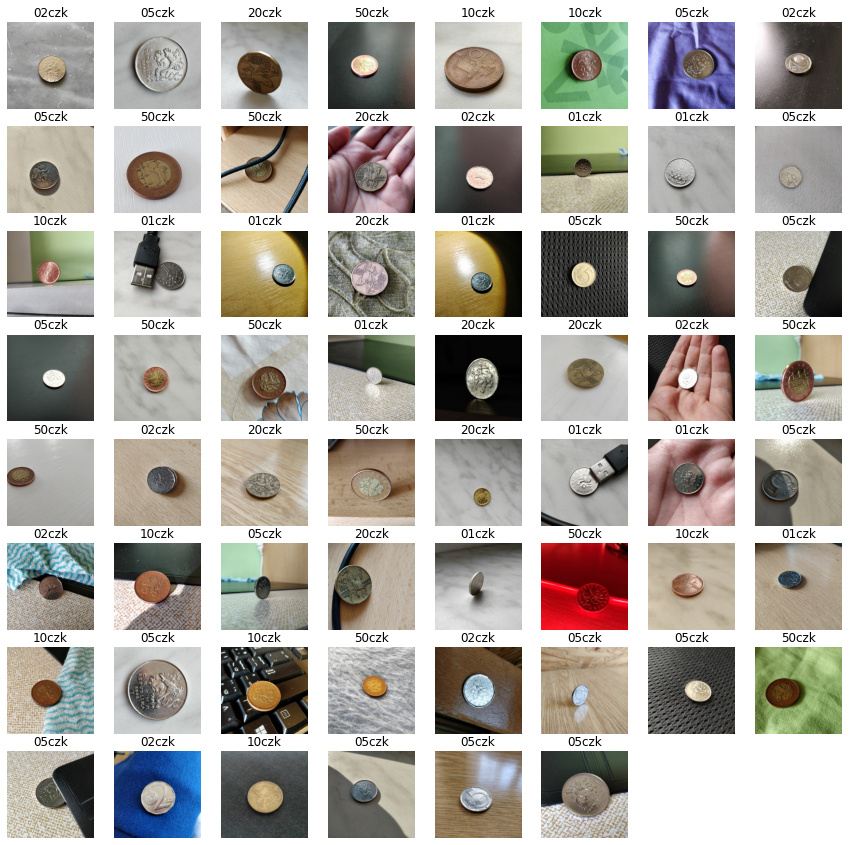

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
24/24 [==============================] - 339s 7s/step - loss: 1.9084 - accuracy: 0.1788 - val_loss: 1.8168 - val_accuracy: 0.1290
Epoch 2/20
24/24 [==============================] - 162s 7s/step - loss: 1.8054 - accuracy: 0.1949 - val_loss: 1.7504 - val_accuracy: 0.2312
Epoch 3/20
24/24 [==============================] - 162s 7s/step - loss: 1.7258 - accuracy: 0.2554 - val_loss: 1.7348 - val_accuracy: 0.2903
Epoch 4/20
24/24 [==============================] - 161s 7s/step - loss: 1.6609 - accuracy: 0.2755 - val_loss: 1.6224 - val_accuracy: 0.3172
Epoch 5/20
24/24 [==============================] - 168s 7s/step - loss: 1.5496 - accuracy: 0.3320 - val_loss: 1.4568 - val_accuracy: 0.3495
Epoch 6/20
24/24 [==============================] - 164s 7s/step - loss: 1.4536 - accuracy: 0.3757 - val_loss: 1.4370 - val_accuracy: 0.3441
Epoch 7/20
24/24 [==============================] - 163s 7s/step - loss: 1.4220 - accuracy: 0.3958 - val_loss: 1.3789 - val_accuracy: 0.3871
Epoch 8/20
24

In [34]:
model.evaluate(test_ds)

4/4 [==============================] - 7s 2s/step - loss: 0.5799 - accuracy: 0.7661


[0.5799389481544495, 0.7661290168762207]

In [35]:
acc = history.history['accuracy']
loss = history.history['loss']

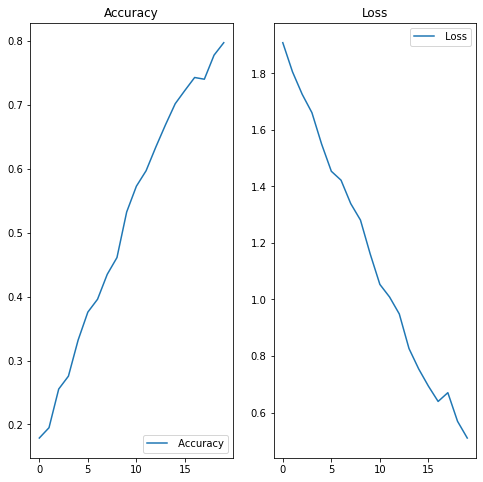

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

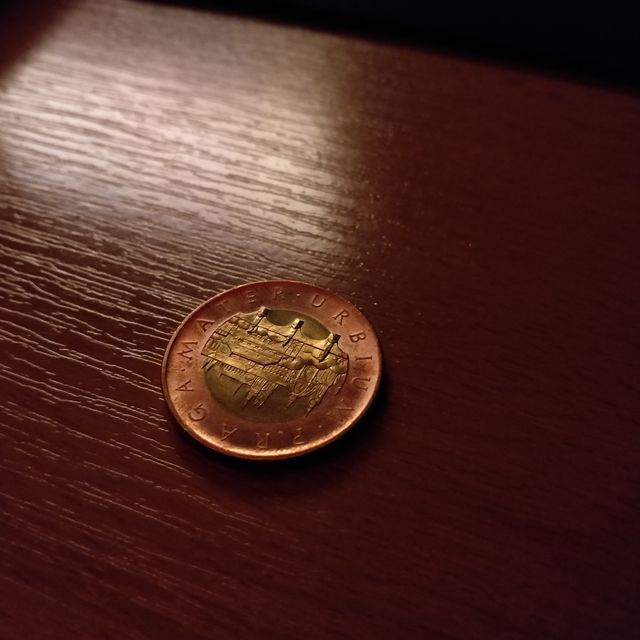

In [29]:
image_path = "/gdrive/MyDrive/50CZK_308.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [30]:
pred = model.predict(scaled_img)

In [31]:
output = class_names[np.argmax(pred)]

In [32]:
output

'50czk'

In [33]:
model.save("Czech_coins.h5")